# **Text Classification and Sentiment Analysis using Natural Language Processing (NLP)**

# Installing libraries we need

In [1]:
!pip install nltk
!pip install textblob
!pip install wordcloud
!pip install lazypredict

# Importing libraries

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np
%matplotlib inline
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import Word, TextBlob
from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from lazypredict.Supervised import LazyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, plot_roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' %x)

# Importing dataset

In [3]:
def load_dataframe(dataset):
    dataframe = pd.read_csv(dataset, sep=',')
    dataframe.columns = [col.lower() for col in dataframe.columns]
    
    return dataframe

df = load_dataframe('/kaggle/input/amazon-review-rating-product-sorting-review/amazon_review.csv')
df.head()

,reviewerid,asin,reviewername,helpful,reviewtext,overall,summary,unixreviewtime,reviewtime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.000,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.000,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.000,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.000,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.000,best deal around,1373673600,2013-07-13,513,0,0


# Text preprocessing

## Let's normalize the case folding

In [4]:
df['reviewtext'] = df['reviewtext'].str.lower()
df['reviewtext']

0                                              no issues.
1       purchased this for my device, it worked as adv...
2       it works as expected. i should have sprung for...
3       this think has worked out great.had a diff. br...
4       bought it with retail packaging, arrived legit...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable. it ...
4913    good amount of space for the stuff i want to d...
4914    i've heard bad things about this 64gb micro sd...
Name: reviewtext, Length: 4915, dtype: object

## Let's remove the punctuation signs using regular expression

In [5]:
df['reviewtext'] = df['reviewtext'].str.replace('[^\w\s]','')
df['reviewtext']

0                                               no issues
1       purchased this for my device it worked as adve...
2       it works as expected i should have sprung for ...
3       this think has worked out greathad a diff bran...
4       bought it with retail packaging arrived legit ...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable it c...
4913    good amount of space for the stuff i want to d...
4914    ive heard bad things about this 64gb micro sd ...
Name: reviewtext, Length: 4915, dtype: object

## Let's remove numbers from the variable using regular expression

In [6]:
df['reviewtext'] = df['reviewtext'].str.replace('\d', '')
df['reviewtext']

0                                               no issues
1       purchased this for my device it worked as adve...
2       it works as expected i should have sprung for ...
3       this think has worked out greathad a diff bran...
4       bought it with retail packaging arrived legit ...
                              ...                        
4910    i bought this sandisk gb class  to use with my...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable it c...
4913    good amount of space for the stuff i want to d...
4914    ive heard bad things about this gb micro sd ca...
Name: reviewtext, Length: 4915, dtype: object

## Let's remove the commonly used words from the variable

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
sw = stopwords.words('english')
df['reviewtext'] = df['reviewtext'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df['reviewtext']

0                                                  issues
1       purchased device worked advertised never much ...
2       works expected sprung higher capacity think ma...
3       think worked greathad diff bran gb card went s...
4       bought retail packaging arrived legit orange e...
                              ...                        
4910    bought sandisk gb class use htc inspire months...
4911    used extending capabilities samsung galaxy not...
4912    great card fast reliable comes optional adapte...
4913          good amount space stuff want fits gopro say
4914    ive heard bad things gb micro sd card crapping...
Name: reviewtext, Length: 4915, dtype: object

## Let's remove rare words from the variable

### We do not know the frequence of each word in the text. Let's fix it.

### 1. Let's create a temporary dataframe to determine the frequency of each word

In [9]:
temp_df = pd.Series(' '.join(df['reviewtext']).split()).value_counts()
temp_df

card          4603
gb            1725
phone         1685
works         1559
great         1445
              ... 
sharper          1
cheapos          1
gate             1
measuring        1
stealwould       1
Length: 9701, dtype: int64

### Let's get and remove the rare words being the frequency is 1

In [10]:
rares = temp_df[temp_df <= 1]
rares
df['reviewtext'] = df['reviewtext'].apply(lambda x: " ".join(x for x in x.split() if x not in rares))
df['reviewtext']

conclusionmy       1
mbsbuy             1
flimsier           1
disappointedtry    1
priceokay          1
                  ..
sharper            1
cheapos            1
gate               1
measuring          1
stealwould         1
Length: 5612, dtype: int64

0                                                  issues
1       purchased device worked advertised never much ...
2       works expected higher capacity think made bit ...
3       think worked gb card went south one held prett...
4       bought retail packaging arrived legit envelope...
                              ...                        
4910    bought sandisk gb class use htc inspire months...
4911    used capabilities samsung galaxy note greatly ...
4912    great card fast reliable comes optional adapte...
4913          good amount space stuff want fits gopro say
4914    ive heard bad things gb micro sd card crapping...
Name: reviewtext, Length: 4915, dtype: object

## Let's tokenize the sentences

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
df['reviewtext'].apply(lambda x: TextBlob(x).words).head()

0                                             [issues]
1    [purchased, device, worked, advertised, never,...
2    [works, expected, higher, capacity, think, mad...
3    [think, worked, gb, card, went, south, one, he...
4    [bought, retail, packaging, arrived, legit, en...
Name: reviewtext, dtype: object

## Let's lemmatize the words

In [13]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [14]:
df['reviewtext'] = df['reviewtext'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['reviewtext']

0                                                   issue
1       purchased device worked advertised never much ...
2       work expected higher capacity think made bit e...
3       think worked gb card went south one held prett...
4       bought retail packaging arrived legit envelope...
                              ...                        
4910    bought sandisk gb class use htc inspire month ...
4911    used capability samsung galaxy note greatly ex...
4912    great card fast reliable come optional adapter...
4913           good amount space stuff want fit gopro say
4914    ive heard bad thing gb micro sd card crapping ...
Name: reviewtext, Length: 4915, dtype: object

# Text visualization

## The problem is how to make the visualization since the texts are not in numerical format. Let's fix this.

In [15]:
tf = df['reviewtext'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ['words', 'tf']
tf.sort_values('tf', ascending=False)

,words,tf
27,card,5537.000
14,work,2044.000
7,phone,1909.000
39,gb,1756.000
98,great,1445.000
...,...,...
2721,sizethe,2.000
2719,everybody,2.000
2717,lived,2.000
3687,chkdsk,2.000


## Line and bar plots

In [16]:
# Since getting all the words is the problem, let's show that the frequency of the words is greater than 500
px.line(tf[tf['tf'] > 500], x='words', y='tf').show()
px.bar(tf[tf['tf'] > 500], x='words', y='tf').show()

## Word cloud

### Let's combine the whole words to get a word cloud

<Figure size 1080x1080 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

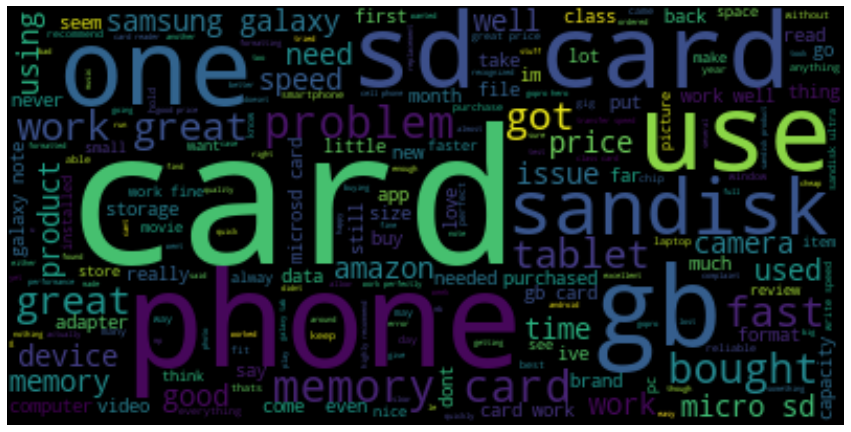

In [17]:
text = " ".join(i for i in df.reviewtext)
word_cloud = WordCloud().generate(text)
plt.figure(figsize=(15, 15))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<Figure size 1080x1080 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

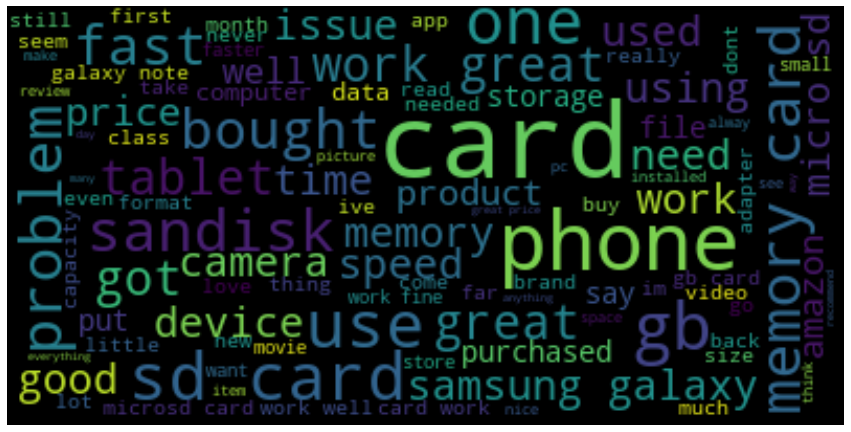

In [18]:
word_cloud = WordCloud(max_font_size=50, max_words=100).generate(text)
plt.figure(figsize=(15, 15))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Sentiment Modeling

## Sentiment analysis

In [19]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [20]:
model = SentimentIntensityAnalyzer()
df['reviewtext'].apply(lambda x:model.polarity_scores(x))

0       {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1       {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2       {'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'comp...
3       {'neg': 0.0, 'neu': 0.798, 'pos': 0.202, 'comp...
4       {'neg': 0.0, 'neu': 0.747, 'pos': 0.253, 'comp...
                              ...                        
4910    {'neg': 0.133, 'neu': 0.727, 'pos': 0.14, 'com...
4911    {'neg': 0.0, 'neu': 0.867, 'pos': 0.133, 'comp...
4912    {'neg': 0.0, 'neu': 0.699, 'pos': 0.301, 'comp...
4913    {'neg': 0.0, 'neu': 0.427, 'pos': 0.573, 'comp...
4914    {'neg': 0.133, 'neu': 0.568, 'pos': 0.299, 'co...
Name: reviewtext, Length: 4915, dtype: object

In [21]:
df['reviewtext'].apply(lambda x:model.polarity_scores(x)['compound']).sort_values(ascending=False)

4212    0.999
2031    0.998
4634    0.992
4423    0.992
3164    0.990
        ...  
821    -0.948
4368   -0.948
3589   -0.957
1904   -0.974
615    -0.993
Name: reviewtext, Length: 4915, dtype: float64

In [22]:
df['polarity_score'] = df['reviewtext'].apply(lambda x:model.polarity_scores(x)['compound'])
df.head()

,reviewerid,asin,reviewername,helpful,reviewtext,overall,summary,unixreviewtime,reviewtime,day_diff,helpful_yes,total_vote,polarity_score
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.000,Four Stars,1406073600,2014-07-23,138,0,0,0.000
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.000,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.000
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.000,nothing to really say....,1356220800,2012-12-23,715,0,0,0.402
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked gb card went south one held prett...,5.000,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.649
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.000,best deal around,1373673600,2013-07-13,513,0,0,0.859


## Sentiment modeling

### Let's create a new variable named 'sentiment_label' to use as a respons in modeling

In [23]:
df['sentiment_label'] = df['reviewtext'].apply(lambda x: 'pos' if model.polarity_scores(x)['compound'] > 0 else 'neg')
df.head()

,reviewerid,asin,reviewername,helpful,reviewtext,overall,summary,unixreviewtime,reviewtime,day_diff,helpful_yes,total_vote,polarity_score,sentiment_label
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.000,Four Stars,1406073600,2014-07-23,138,0,0,0.000,neg
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.000,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.000,neg
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.000,nothing to really say....,1356220800,2012-12-23,715,0,0,0.402,pos
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked gb card went south one held prett...,5.000,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.649,pos
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.000,best deal around,1373673600,2013-07-13,513,0,0,0.859,pos


### Let's check the distribution of the new variable

In [24]:
df['sentiment_label'].value_counts()
px.histogram(df, x='sentiment_label').show()

pos    3944
neg     971
Name: sentiment_label, dtype: int64

### Let's encode the dependent variable 'sentiment_label'

In [25]:
df['sentiment_label'] = LabelEncoder().fit_transform(df['sentiment_label'])
df.head()

,reviewerid,asin,reviewername,helpful,reviewtext,overall,summary,unixreviewtime,reviewtime,day_diff,helpful_yes,total_vote,polarity_score,sentiment_label
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.000,Four Stars,1406073600,2014-07-23,138,0,0,0.000,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.000,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.000,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.000,nothing to really say....,1356220800,2012-12-23,715,0,0,0.402,1
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked gb card went south one held prett...,5.000,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.649,1
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.000,best deal around,1373673600,2013-07-13,513,0,0,0.859,1


### Let's select the independent and dependent variables

In [26]:
X = df['reviewtext']
y = df['sentiment_label']

### Let's create independent variables from the independent variable 'sentiment_label' using count vector

### The most important point of NLP studies is the numerical representation of texts and words, namely the vectorization of the words. For this, 'count, vector, TF-IDF and Word Embeddings' methods are used. 'ngram' refers to generating features based on phrases.

### Count Vectors

### ngram

In [27]:
ngram_text = "The most important point of NLP studies is the numerical representation of texts and words, namely the vectorization of the words. For this, 'count, vector, TF-IDF and Word Embeddings' methods are used. 'ngram' refers to generating features based on phrases."
TextBlob(ngram_text).ngrams(3)

[WordList(['The', 'most', 'important']),
 WordList(['most', 'important', 'point']),
 WordList(['important', 'point', 'of']),
 WordList(['point', 'of', 'NLP']),
 WordList(['of', 'NLP', 'studies']),
 WordList(['NLP', 'studies', 'is']),
 WordList(['studies', 'is', 'the']),
 WordList(['is', 'the', 'numerical']),
 WordList(['the', 'numerical', 'representation']),
 WordList(['numerical', 'representation', 'of']),
 WordList(['representation', 'of', 'texts']),
 WordList(['of', 'texts', 'and']),
 WordList(['texts', 'and', 'words']),
 WordList(['and', 'words', 'namely']),
 WordList(['words', 'namely', 'the']),
 WordList(['namely', 'the', 'vectorization']),
 WordList(['the', 'vectorization', 'of']),
 WordList(['vectorization', 'of', 'the']),
 WordList(['of', 'the', 'words']),
 WordList(['the', 'words', 'For']),
 WordList(['words', 'For', 'this']),
 WordList(['For', 'this', "'count"]),
 WordList(['this', "'count", 'vector']),
 WordList(["'count", 'vector', 'TF-IDF']),
 WordList(['vector', 'TF-IDF'

In [28]:
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)
# vectorizer.get_feature_names()
X_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### TF-IDF method

#### This method is a normalized, standardized word vector generation method to remove some of the biases that the 'count vector' method may introduce.

In [29]:
tfidf_vectorizer_word = TfidfVectorizer()
X_tfidf_word = tfidf_vectorizer_word.fit_transform(X) # Word frequency
tfidf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tfidf_gram = tfidf_ngram_vectorizer.fit_transform(X) # ngram frequency

## Logistic regression model

### Count vectorizer

In [30]:
log_model_count = LogisticRegression().fit(X_count, y)

In [31]:
log_model_count.intercept_
log_model_count.coef_

array([-0.32158808])

array([[0.22176942, 0.03387786, 0.06604038, ..., 0.39747638, 0.03654815,
        0.22775039]])

In [32]:
y_pred_count = log_model_count.predict(X_count)
print(classification_report(y, y_pred_count))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93       971
           1       0.98      0.99      0.98      3944

    accuracy                           0.97      4915
   macro avg       0.97      0.95      0.96      4915
weighted avg       0.97      0.97      0.97      4915



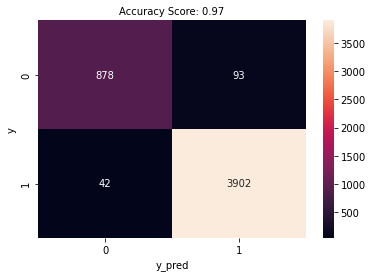

In [33]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred_count)

In [34]:
y_prob_count = log_model_count.predict_proba(X_count)[:, 1]
print('The roc_auc_score is', round(roc_auc_score(y, y_prob_count), 3))

The roc_auc_score is 0.991


In [35]:
print('The accuracy score is', round(cross_val_score(log_model_count, X_count, y, cv=10, scoring='accuracy').mean(), 3))
print('The recall score is', round(cross_val_score(log_model_count, X_count, y, cv=10, scoring='recall').mean(), 3))
print('The precision score is', round(cross_val_score(log_model_count, X_count, y, cv=10, scoring='precision').mean(), 3))
print('The f1 score is', round(cross_val_score(log_model_count, X_count, y, cv=10, scoring='f1').mean(), 3))
print('The roc auc score is', round(cross_val_score(log_model_count, X_count, y, cv=10, scoring='roc_auc').mean(), 3))

The accuracy score is 0.869
The recall score is 0.942
The precision score is 0.9
The f1 score is 0.92
The roc auc score is 0.898


### TF-IDF method for word level

In [36]:
logistic_model_word = LogisticRegression().fit(X_tfidf_word, y)

In [37]:
logistic_model_word.intercept_
logistic_model_word.coef_

array([0.42560833])

array([[ 0.16673121, -0.33806135,  0.13271863, ...,  0.21211752,
         0.10352387,  0.10112967]])

In [38]:
y_pred_word = logistic_model_word.predict(X_tfidf_word)
print(classification_report(y, y_pred_word))

              precision    recall  f1-score   support

           0       0.95      0.38      0.54       971
           1       0.87      1.00      0.93      3944

    accuracy                           0.87      4915
   macro avg       0.91      0.69      0.73      4915
weighted avg       0.88      0.87      0.85      4915



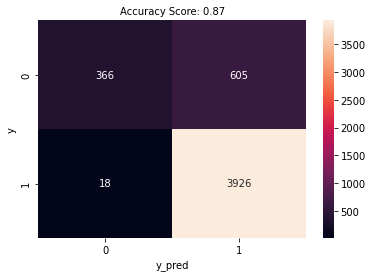

In [39]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred_word)

In [40]:
y_prob_word = logistic_model_word.predict_proba(X_tfidf_word)[:, 1]
print('The roc_auc_score is', round(roc_auc_score(y, y_prob_word), 3))

The roc_auc_score is 0.965


### Cross validation for word level

In [41]:
print('The accuracy score is', round(cross_val_score(logistic_model_word, X_tfidf_word, y, cv=10, scoring='accuracy').mean(), 3))
print('The recall score is', round(cross_val_score(logistic_model_word, X_tfidf_word, y, cv=10, scoring='recall').mean(), 3))
print('The precision score is', round(cross_val_score(logistic_model_word, X_tfidf_word, y, cv=10, scoring='precision').mean(), 3))
print('The f1 score is', round(cross_val_score(logistic_model_word, X_tfidf_word, y, cv=10, scoring='f1').mean(), 3))
print('The roc auc score is', round(cross_val_score(logistic_model_word, X_tfidf_word, y, cv=10, scoring='roc_auc').mean(), 3))

The accuracy score is 0.832
The recall score is 0.989
The precision score is 0.833
The f1 score is 0.904
The roc auc score is 0.894


### TF-IDF method for ngram level

In [42]:
logistic_model_ngram = LogisticRegression().fit(X_tfidf_gram, y)

In [43]:
logistic_model_ngram.intercept_
logistic_model_ngram.coef_

array([1.32224869])

array([[0.00477355, 0.00477355, 0.01747254, ..., 0.02534214, 0.02272092,
        0.02272092]])

In [44]:
y_pred_ngram = logistic_model_ngram.predict(X_tfidf_gram)
print(classification_report(y, y_pred_ngram))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       971
           1       0.80      1.00      0.89      3944

    accuracy                           0.80      4915
   macro avg       0.40      0.50      0.45      4915
weighted avg       0.64      0.80      0.71      4915



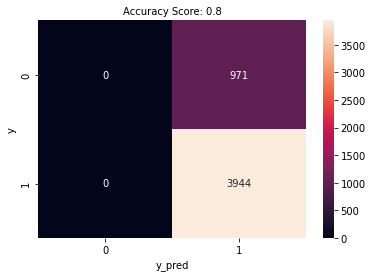

In [45]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred_ngram)

In [46]:
y_prob_ngram = logistic_model_ngram.predict_proba(X_tfidf_gram)[:, 1]
print('The roc_auc_score is', round(roc_auc_score(y, y_prob_ngram), 3))

The roc_auc_score is 1.0


### Cross validation for ngram level

In [47]:
print('The accuracy score is', round(cross_val_score(logistic_model_ngram, X_tfidf_gram, y, cv=10, scoring='accuracy').mean(), 3))
print('The recall score is', round(cross_val_score(logistic_model_ngram, X_tfidf_gram, y, cv=10, scoring='recall').mean(), 3))
print('The precision score is', round(cross_val_score(logistic_model_ngram, X_tfidf_gram, y, cv=10, scoring='precision').mean(), 3))
print('The f1 score is', round(cross_val_score(logistic_model_ngram, X_tfidf_gram, y, cv=10, scoring='f1').mean(), 3))
print('The roc auc score is', round(cross_val_score(logistic_model_ngram, X_tfidf_gram, y, cv=10, scoring='roc_auc').mean(), 3))

The accuracy score is 0.802
The recall score is 1.0
The precision score is 0.802
The f1 score is 0.89
The roc auc score is 0.77


### Let's make a prediction using logistic regression model

In [48]:
# Cont vector
new_review = pd.Series('this is a great product')
new_review = TfidfVectorizer().fit(X).transform(new_review)
log_model_count.predict(new_review)

random_review = pd.Series(df['reviewtext'].sample(1).values)
random_review = TfidfVectorizer().fit(X).transform(random_review)
log_model_count.predict(random_review)

array([1])

array([1])

In [49]:
# TF-IDF method
new_review = pd.Series('this is a great product')
new_review = TfidfVectorizer().fit(X).transform(new_review)
logistic_model_word.predict(new_review)

random_review = pd.Series(df['reviewtext'].sample(1).values)
random_review = TfidfVectorizer().fit(X).transform(random_review)
logistic_model_word.predict(random_review)

array([1])

array([1])

## KNN model

### Count Vectorizer

In [50]:
knn_model_count = KNeighborsClassifier().fit(X_count, y)

In [51]:
y_pred_count_knn = knn_model_count.predict(X_count)
print(classification_report(y, y_pred_count_knn))

              precision    recall  f1-score   support

           0       0.51      0.72      0.60       971
           1       0.92      0.83      0.87      3944

    accuracy                           0.81      4915
   macro avg       0.72      0.78      0.74      4915
weighted avg       0.84      0.81      0.82      4915



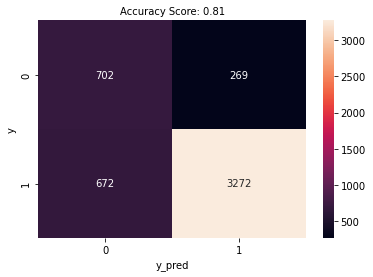

In [52]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred_count_knn)

In [53]:
y_prob_count_knn = knn_model_count.predict_proba(X_count)[:, 1]
print('The roc_auc_score is', round(roc_auc_score(y, y_prob_count_knn), 3))

The roc_auc_score is 0.864


In [54]:
print('The accuracy score is', round(cross_val_score(knn_model_count, X_count, y, cv=10, scoring='accuracy').mean(), 3))
print('The recall score is', round(cross_val_score(knn_model_count, X_count, y, cv=10, scoring='recall').mean(), 3))
print('The precision score is', round(cross_val_score(knn_model_count, X_count, y, cv=10, scoring='precision').mean(), 3))
print('The f1 score is', round(cross_val_score(knn_model_count, X_count, y, cv=10, scoring='f1').mean(), 3))
print('The roc auc score is', round(cross_val_score(knn_model_count, X_count, y, cv=10, scoring='roc_auc').mean(), 3))

The accuracy score is 0.71
The recall score is 0.752
The precision score is 0.869
The f1 score is 0.806
The roc auc score is 0.713


### TF-IDF method word level

In [55]:
knn_model_word = KNeighborsClassifier().fit(X_tfidf_word, y)

In [56]:
y_pred_word_knn = knn_model_word.predict(X_tfidf_word)
print(classification_report(y, y_pred_word_knn))

              precision    recall  f1-score   support

           0       0.64      0.65      0.64       971
           1       0.91      0.91      0.91      3944

    accuracy                           0.86      4915
   macro avg       0.78      0.78      0.78      4915
weighted avg       0.86      0.86      0.86      4915



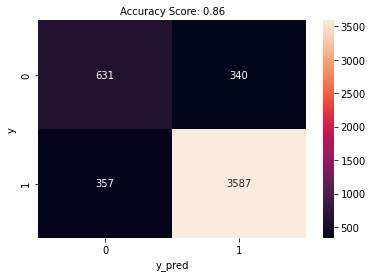

In [57]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred_word_knn)

In [58]:
y_prob_word_knn = knn_model_word.predict_proba(X_tfidf_word)[:, 1]
print('The roc_auc_score is', round(roc_auc_score(y, y_prob_word_knn), 3))

The roc_auc_score is 0.893


In [59]:
print('The accuracy score is', round(cross_val_score(knn_model_word, X_tfidf_word, y, cv=10, scoring='accuracy').mean(), 3))
print('The recall score is', round(cross_val_score(knn_model_word, X_tfidf_word, y, cv=10, scoring='recall').mean(), 3))
print('The precision score is', round(cross_val_score(knn_model_word, X_tfidf_word, y, cv=10, scoring='precision').mean(), 3))
print('The f1 score is', round(cross_val_score(knn_model_word, X_tfidf_word, y, cv=10, scoring='f1').mean(), 3))
print('The roc auc score is', round(cross_val_score(knn_model_word, X_tfidf_word, y, cv=10, scoring='roc_auc').mean(), 3))

The accuracy score is 0.761
The recall score is 0.87
The precision score is 0.838
The f1 score is 0.853
The roc auc score is 0.665


### TF-IDF method ngram level

In [60]:
knn_model_ngram = KNeighborsClassifier().fit(X_tfidf_gram, y)

In [61]:
y_pred_ngram_knn = knn_model_ngram.predict(X_tfidf_gram)
print(classification_report(y, y_pred_ngram_knn))

              precision    recall  f1-score   support

           0       0.33      0.79      0.47       971
           1       0.92      0.62      0.74      3944

    accuracy                           0.65      4915
   macro avg       0.63      0.70      0.60      4915
weighted avg       0.81      0.65      0.68      4915



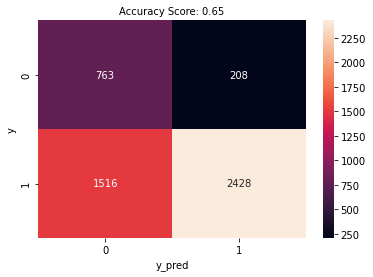

In [62]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred_ngram_knn)

In [63]:
y_prob_ngram_knn = knn_model_ngram.predict_proba(X_tfidf_gram)[:, 1]
print('The roc_auc_score is', round(roc_auc_score(y, y_prob_ngram_knn), 3))

The roc_auc_score is 0.759


In [64]:
print('The accuracy score is', round(cross_val_score(knn_model_ngram, X_tfidf_gram, y, cv=10, scoring='accuracy').mean(), 3))
print('The recall score is', round(cross_val_score(knn_model_ngram, X_tfidf_gram, y, cv=10, scoring='recall').mean(), 3))
print('The precision score is', round(cross_val_score(knn_model_ngram, X_tfidf_gram, y, cv=10, scoring='precision').mean(), 3))
print('The f1 score is', round(cross_val_score(knn_model_ngram, X_tfidf_gram, y, cv=10, scoring='f1').mean(), 3))
print('The roc auc score is', round(cross_val_score(knn_model_ngram, X_tfidf_gram, y, cv=10, scoring='roc_auc').mean(), 3))

The accuracy score is 0.398
The recall score is 0.337
The precision score is 0.795
The f1 score is 0.471
The roc auc score is 0.491


### Let's make a prediction using KNN model

In [65]:
# Cont vector
new_review = pd.Series('this is a bad product')
new_review = TfidfVectorizer().fit(X).transform(new_review)
knn_model_count.predict(new_review)

random_review = pd.Series(df['reviewtext'].sample(1).values)
random_review = TfidfVectorizer().fit(X).transform(random_review)
knn_model_count.predict(random_review)

array([0])

array([0])

In [66]:
# TF-IDF method
new_review = pd.Series('this is a bad product')
new_review = TfidfVectorizer().fit(X).transform(new_review)
knn_model_word.predict(new_review)

random_review = pd.Series(df['reviewtext'].sample(1).values)
random_review = TfidfVectorizer().fit(X).transform(random_review)
knn_model_word.predict(random_review)

array([0])

array([1])

### Random forest model

### Count vectorizer

In [67]:
rf_model_count = RandomForestClassifier().fit(X_count, y)

In [68]:
y_pred_count_rf = rf_model_count.predict(X_count)
print(classification_report(y, y_pred_count_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       971
           1       1.00      1.00      1.00      3944

    accuracy                           1.00      4915
   macro avg       1.00      1.00      1.00      4915
weighted avg       1.00      1.00      1.00      4915



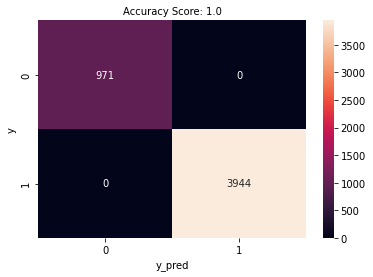

In [69]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred_count_rf)

In [70]:
y_prob_count_rf = rf_model_count.predict_proba(X_count)[:, 1]
print('The roc_auc_score is', round(roc_auc_score(y, y_prob_count_rf), 3))

The roc_auc_score is 1.0


In [71]:
print('The accuracy score is', round(cross_val_score(rf_model_count, X_count, y, cv=10, scoring='accuracy').mean(), 3))
print('The recall score is', round(cross_val_score(rf_model_count, X_count, y, cv=10, scoring='recall').mean(), 3))
print('The precision score is', round(cross_val_score(rf_model_count, X_count, y, cv=10, scoring='precision').mean(), 3))
print('The f1 score is', round(cross_val_score(rf_model_count, X_count, y, cv=10, scoring='f1').mean(), 3))
print('The roc auc score is', round(cross_val_score(rf_model_count, X_count, y, cv=10, scoring='roc_auc').mean(), 3))

The accuracy score is 0.844
The recall score is 0.978
The precision score is 0.848
The f1 score is 0.91
The roc auc score is 0.888


### TF-IDF method for word level

In [72]:
rf_model_word = RandomForestClassifier().fit(X_tfidf_word, y)

In [73]:
y_pred_word_rf = rf_model_word.predict(X_tfidf_word)
print(classification_report(y, y_pred_word_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       971
           1       1.00      1.00      1.00      3944

    accuracy                           1.00      4915
   macro avg       1.00      1.00      1.00      4915
weighted avg       1.00      1.00      1.00      4915



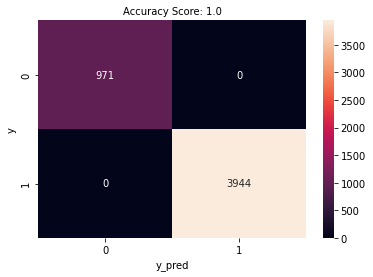

In [74]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred_word_rf)

In [75]:
y_prob_word_rf = rf_model_word.predict_proba(X_tfidf_word)[:, 1]
print('The roc_auc_score is', round(roc_auc_score(y, y_prob_word_rf), 3))

The roc_auc_score is 1.0


In [76]:
print('The accuracy score is', round(cross_val_score(rf_model_word, X_tfidf_word, y, cv=10, n_jobs=-1, scoring='accuracy').mean(), 3))
print('The recall score is', round(cross_val_score(rf_model_word, X_tfidf_word, y, cv=10, n_jobs=-1, scoring='recall').mean(), 3))
print('The precision score is', round(cross_val_score(rf_model_word, X_tfidf_word, y, cv=10, n_jobs=-1, scoring='precision').mean(), 3))
print('The f1 score is', round(cross_val_score(rf_model_word, X_tfidf_word, y, cv=10, n_jobs=-1, scoring='f1').mean(), 3))
print('The roc auc score is', round(cross_val_score(rf_model_word, X_tfidf_word, y, cv=10, n_jobs=-1, scoring='roc_auc').mean(), 3))

The accuracy score is 0.83
The recall score is 0.987
The precision score is 0.833
The f1 score is 0.902
The roc auc score is 0.866


### TF-IDF method ngram level

In [77]:
rf_model_ngram = RandomForestClassifier().fit(X_tfidf_gram, y)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       971
           1       1.00      1.00      1.00      3944

    accuracy                           1.00      4915
   macro avg       1.00      1.00      1.00      4915
weighted avg       1.00      1.00      1.00      4915



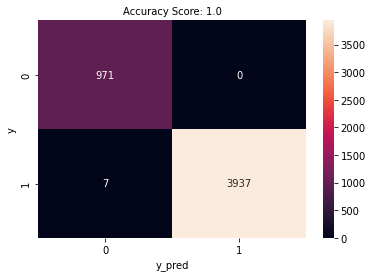

In [78]:
y_pred_ngram_rf = rf_model_ngram.predict(X_tfidf_gram)
print(classification_report(y, y_pred_ngram_rf))

def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred_ngram_rf)

In [79]:
y_prob_ngram_rf = rf_model_ngram.predict_proba(X_tfidf_gram)[:, 1]
print('The roc_auc_score is', round(roc_auc_score(y, y_prob_ngram_rf), 3))

The roc_auc_score is 1.0


In [80]:
# for ngrams
# print('The accuracy score is', round(cross_val_score(rf_model_ngram, X_tfidf_gram, y, cv=10, n_jobs=-1, scoring='accuracy').mean(), 3))
# print('The recall score is', round(cross_val_score(rf_model_ngram, X_tfidf_gram, y, cv=10, n_jobs=-1, scoring='recall').mean(), 3))
# print('The precision score is', round(cross_val_score(rf_model_ngram, X_tfidf_gram, y, cv=10, n_jobs=-1, scoring='precision').mean(), 3))
# print('The f1 score is', round(cross_val_score(rf_model_ngram, X_tfidf_gram, y, cv=10, n_jobs=-1, scoring='f1').mean(), 3))
# print('The roc auc score is', round(cross_val_score(rf_model_ngram, X_tfidf_gram, y, cv=10, n_jobs=-1, scoring='roc_auc').mean(), 3))

# Results
# The accuracy score is 0.785
# The recall score is 0.948
# The precision score is 0.818
# The f1 score is 0.878
# The roc auc score is 0.701

### Let's make a prediction using Random Forest model

In [81]:
# Cont vector
new_review = pd.Series('this is a bad product')
new_review = TfidfVectorizer().fit(X).transform(new_review)
rf_model_count.predict(new_review)

random_review = pd.Series(df['reviewtext'].sample(1).values)
random_review = TfidfVectorizer().fit(X).transform(random_review)
rf_model_count.predict(random_review)

array([0])

array([0])

In [82]:
# TF-IDF method
new_review = pd.Series('this is a bad product')
new_review = TfidfVectorizer().fit(X).transform(new_review)
rf_model_word.predict(new_review)

random_review = pd.Series(df['reviewtext'].sample(1).values)
random_review = TfidfVectorizer().fit(X).transform(random_review)
rf_model_word.predict(random_review)

array([0])

array([0])

# **Thank you for checking my notebook! If you enjoy my notebook when you evaluated, I appreciate for your vote and comment in advance.**